Before beginning this exercise you must download some data files, which can be retrieved from here: 

https://northwestern.box.com/s/rsb5wjb7dztg2128flzgex4fmq19havu

Be sure to move the corresponding files to the directory where you are running this notebook. Furthermore, you will need to provide the path to these data as the variable `dataDir`, below.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import numpy as np
import matplotlib.pyplot as plt

from rhlUtils import BBox, CCD, Image, imshow

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

dataDir = # complete
mag0 = 33   # Magnitude of an object with 1 detected photon

We have provided three images containing stars, taken with 3 different CCDs, in "stars_X.npz" where X = 0, 1, 2.
The true magnitudes of all the stars are also known, taken from a reliable reference catalogue.

OK, I'll be honest; these are simulations.  The stars' centers are all at centres of pixels
make your lives easier; there is no spatial structure in the PSF; and there is also no noise added of any kind.  You may buy me a drink later.

To read the image data and the calibs say something like:

In [2]:
data = np.load(os.path.join(dataDir, "stars_0.npz"))
image, calibs = data["image"], data["calibs"]

image0, calibs0 = image.copy(), calibs    # Keep copies

Just to make sure that we're all on the same page, here's code to display the image and stars (imshow is a simple utility imported from rhlUtils -- feel free to use plt.imshow if you'd rather)

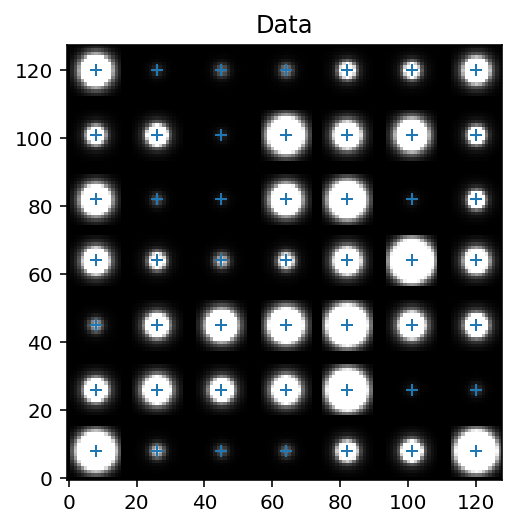

In [3]:
plt.figure(1)
plt.clf()
imshow(image, vmin=0, vmax=1000)
plt.title("Data")

plt.plot(calibs[:, 0], calibs[:, 1], '+')   # calibs[:, 2] contains the object's magnitude (not flux)

plt.show()

Time for you to do some work.  Write some code to estimate a PSF model by simply averaging all the objects, giving each equal weight.  You should add the option to use only some subset of the stars (e.g. the faintest 25%).

Your model should simply be an image of the PSF, normalised to have a maximum value of 1.0

You could use the calibs object to find all the stars, but in the real world there are stars in the data that are
not in the catalogue so you'll have to write a simple object finder (i.e. don't use the calibs!).  It's sufficient to find pixels that are larger than any neighbours to the left, right, top, or bottom; no, this isn't quite how you'd do it in the real world but it's not far off.

I told you that there were three data sets, taken in different places on the sky and with CCDs with different properties.  Choose one set (e.g. "stars_0.npz") to carry out the following activities, then go back and look at the other two.

---

Here's my version of code do estimate the PSF.  I wrote my own naive object finder for DSFP;  in reality I'd call the one in the LSST stack (which has heritage stretching back to SDSS via PanSTARRS).

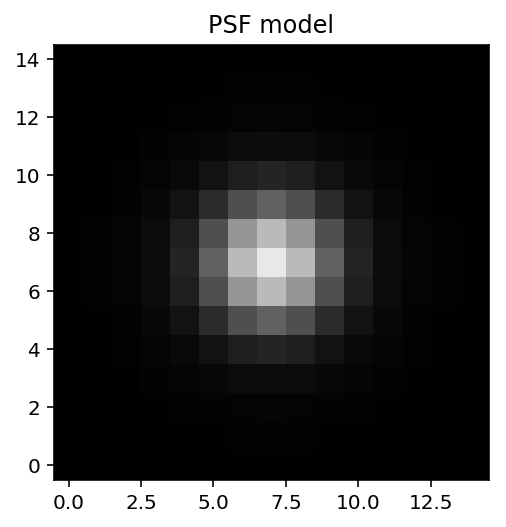

In [4]:
def makePsfModel(image, pmin=0, pmax=100):
    """Return an image which is a model of the PSF
    
    Only use stars which lie within the pmin and pmax percentiles (inclusive)
    """
    yc, xc = np.where(np.logical_and.reduce([image > np.roll(image.copy(), (1,  0), (0, 1)), 
                                             image > np.roll(image.copy(), (-1, 0), (0, 1)),
                                             image > np.roll(image.copy(), (0,  1), (0, 1)), 
                                             image > np.roll(image.copy(), (0, -1), (0, 1)),
                                ]))
    I0 = image[yc, xc]

    psfSize = 15
    psfIm = np.zeros((psfSize, psfSize))
    for x, y, I in zip(xc, yc, I0):
        if I >= np.percentile(I0, [pmin]) and I <= np.percentile(I0, [pmax]):
            dpsf = image[y - psfSize//2:y + psfSize//2 + 1, x - psfSize//2:x + psfSize//2 + 1].copy()
            dpsf /= dpsf.max()

            psfIm += dpsf

    psfIm /= psfIm.max()
    
    return psfIm, xc, yc
    
psfIm, xc, yc = makePsfModel(image)
imshow(psfIm, vmin=0, vmax=1.1)
plt.title("PSF model");

OK, now use your PSF model to create an image of the residuals created by subtracting the scaled PSF from the stars.

How does it look?  Do you see what's going on?  Remember, I said that the PSF isn't a function of position, but CCDs aren't perfect.

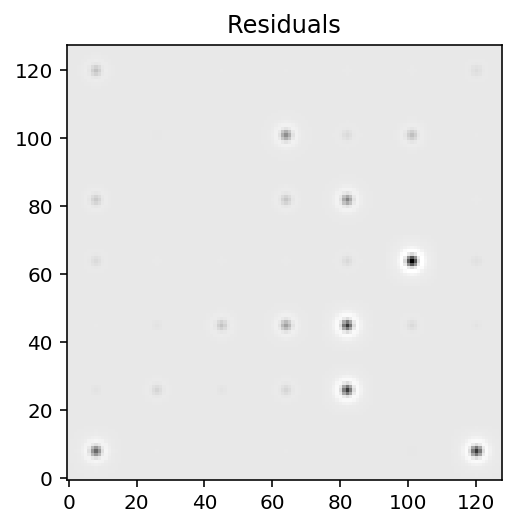

In [5]:
image = image0.copy()

psfSize = psfIm.shape[0]
for x, y in zip(xc, yc):
    sub = image[y - psfSize//2:y + psfSize//2 + 1, x - psfSize//2:x + psfSize//2 + 1]
    
    sub -= psfIm*sub.sum()/psfIm.sum()

imshow(image, vmin=image.min(), vmax=image.max()) # , vmin=0, vmax=100)
plt.title("Residuals");

A powerful diagnostic is to measure the fluxes of the objects in different ways, and compare with the truth (i.e. the
magnitudes given in the calibs data structure).

For the purpose of this exercise you should use:
- aperture fluxes (the sum of all the pixels in a square centred on the star is good enough)
- psf fluxes (the flux in the best-fit PSF model, $\phi$.  The amplitude is simply $A = \frac{\sum \phi I}{\sum \phi^2}$, and the flux is $A \sum \phi$)

Convert them to magnitudes using the known zero-point mag0 (the magnitude corresponding to one count), and make suitable plots.

What do you think is going on?  Are there other measurements that you can make on the data to test your hypotheses?  Are there other observations that you'd like (I might be able to make them for you).

In [6]:
def plotMags(image, calibs, yLabels=True):
    apFlux =   np.empty_like(xc, dtype='float')
    calibMag = np.empty_like(apFlux)
    psfFlux =  np.empty_like(apFlux)

    for i, (x, y) in enumerate(zip(xc, yc)):
        sub = image[y - psfSize//2:y + psfSize//2 + 1, x - psfSize//2:x + psfSize//2 + 1]

        apFlux[i] = sub.sum()
        psfFlux[i] = psfIm.sum()*np.sum(psfIm*sub)/np.sum(psfIm**2)

        delta = np.hypot(x - calibs[:, 0], y - calibs[:, 1])
        iDelta = np.argmin(delta)
        calibMag[i] = calibs[iDelta, 2]

    apMag = mag0 - 2.5*np.log10(apFlux)
    psfMag = mag0 - 2.5*np.log10(psfFlux)

    plt.plot(apMag, psfMag - apMag, 'o', label="psf")
    plt.plot(apMag, calibMag - apMag, 'o', label="ap")

    plt.ylim(-0.11, 0.11)
    if yLabels:
        plt.ylabel('xxMag - apMag');
    else:
        plt.gca().set_yticklabels([])
        
    plt.xlabel('apMag')

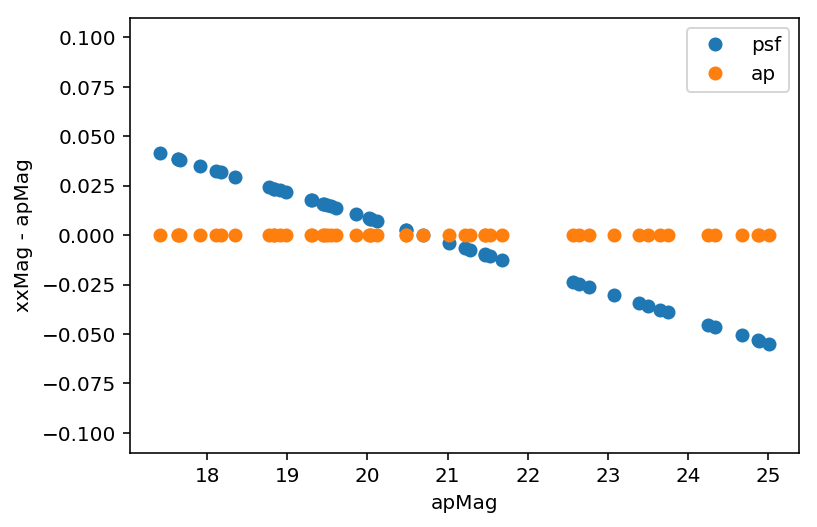

In [7]:
plotMags(image0, calibs0)
plt.legend();

Now we can make plots for all three images.  I only use the faintest 5% of the stars to estimate the PSF,
you'll see why in a moment.

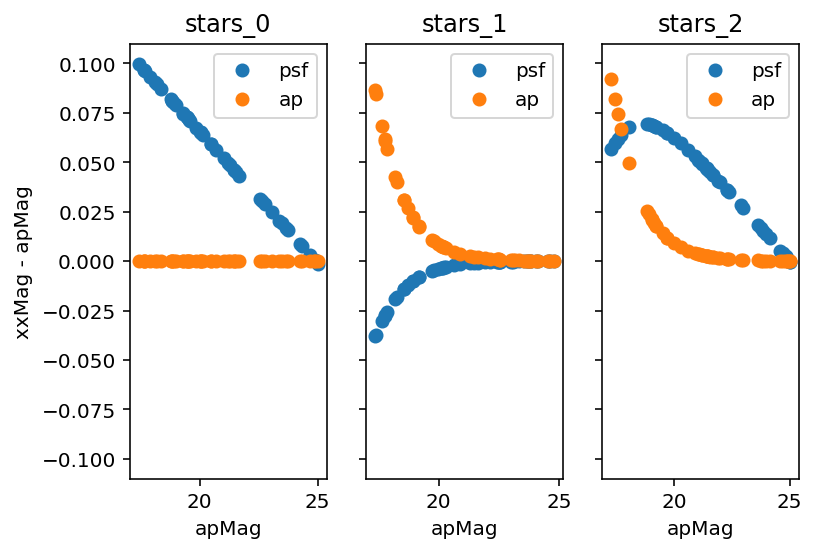

In [8]:
for i in range(3):
    data = np.load(os.path.join(dataDir, "stars_%d.npz" % i))
    image, calibs = data["image"], data["calibs"]
    
    psfIm = makePsfModel(image.copy(), 0, 5)[0]

    plt.subplot(1, 3, i+1)

    plotMags(image.copy(), calibs, i==0)
    plt.legend()
    plt.title("stars_%d" % (i))

- The first one (`stars_0.npz`) is simple;  the aperture magnitudes are correct but the PSF magnitudes are biased.  This must be brigher-fatter which redistributes flux but measures it correctly. The PSF model is correct for the faintest stars (that's why I chose to estimate it from the 5% faintest stars)
- The second (`1`) gives a consistent magnitudes between the `psf` and `ap` magnitudes for faint objects, so it's due to non-linearity in the electronics.
- The third (`2`) is messier, and corresponds to the case where there is both brighter-fatter _and_ non-linearity  Once again, all is well for the faintest stars as those are the ones I used to estimate the PSF.  The plot makes sense if you look at `0` and `1`.

---

If you change the `makePsfModel` call to `psfIm = makePsfModel(image, 95, 100)[0]` you'll see that
 - The `0` fluxes now agree at the *bright* end (where the PSF model is correct)
 - The `1` fluxes have a constant offset at the faint end as the faint PSF model is now wrong (non-linearity changes the stars' profiles).
 - The `2` fluxes are still a mess.